# Using a shapefile to select a region and calculate statistics

Shapefile is a geospatial format used by geographic information system (GIS) software to display vector data. Shapefiles can be used to define complex polygons and shapes like states, regions, ocean basins. 
In this notebook we show how you can use a shapefile to select a specific region from a gridded dataset.
<br>
We will be showing two different methods using the following modules:
* **geopandas** to read the polygons defined in the shapefile
* **rasterio** and **odc** to create a gridded mask for each polygon 
* **xarray** to read the gridded model data and apply the mask
* **rasterstats** to calculate zonal statistics on the region

In [2]:
from rasterstats import zonal_stats
import rasterio
import pandas as pd
import xarray as xr
import geopandas as gpd
import odc.geo.xr
import os

Here we are using the AGCD precipitation data and a shapefile of the Eastern Seaboard region.

In [3]:
# Filepaths
shapefile = '/g/data/hh5/tmp/blog/FebMar_ESB_MaryRiver_to_NSW_Vic_border_clip.shx'
ncfile = '/g/data/zv2/agcd/v1/precip/total/r005/01day/agcd_v1_precip_total_r005_daily_1999.nc'
ncfiles = '/g/data/zv2/agcd/v1/precip/total/r005/01day/agcd_v1_precip_total_r005_daily_*.nc'

We are using the AGCD data to calculate the mean precipitation in a region defined by the shapefile, but any other dataset covering the same region will do. 

In [4]:
ds = xr.open_dataset(ncfile, chunks={'time': '200MB'}, decode_coords='all')
precip = ds.precip
precip

<xarray.DataArray 'precip' (time: 365, lat: 691, lon: 886)>
dask.array<open_dataset-151f7e306d0cdfd24c3c90d220556f3aprecip, shape=(365, 691, 886), dtype=float32, chunksize=(81, 691, 886), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1999-01-01T09:00:00 ... 1999-12-31T09:00:00
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
    crs      int32 ...
Attributes:
    cell_methods:                  time: sum
    units:                         mm
    analysis_version_number:       3.01
    long_name:                     Daily precipitation
    number_of_stations_reporting:  6276
    standard_name:                 lwe_thickness_of_precipitation_amount
    frequency:                     daily
    length_scale_for_analysis:     80.0
    coverage_content_type:         physicalMeasurement
    valid_range:                   [     0. 100000.]

NB I used decode_coords='all' so it will load the variables referred to in 'grid_mapping', 'bounds' and other attributes as coordinate variables.

## Using zonal_stats
The `rasterstats` package has a `zonal_stats` method which calculate statistics on regions defined by shapefiles.<br>
To use `zonal_stats` we open the netcdf file as a raster, using `rasterio`, and we generate a mapping of the array dimensions to a coordinate reference system (affine). See:<br>
https://pythonhosted.org/rasterstats/manual.html#raster-data-sources.<br>
`rasterio` can read and write data in raster formats, including reading gridded datasets as raster.<br>
Then we loop over each timestep calling zonal_stats() and converting the resulting dictionary to a pandas dataframe.
Each dataframe is appended to a list so it can be easily concatenated later on.<br>
`zonal_stats` takes as input the shapefile, the numpy array with the data from each timesteps and affine.

In [5]:
# added a loop to read all the arrays for each timesteps
stats_list = []
steps = len(precip.time)
with rasterio.open(f'netcdf:{ncfile}:precip') as src:
    affine = src.transform
    for i in range(1,steps+1):
        array = src.read(i)
        stats_list.append(pd.DataFrame(zonal_stats(
        shapefile, array, stats='mean', affine=affine)))

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


NB by default `zonal_stats` returns four statistics: mean, min, max and count. Here we selected only `mean`.<br><br>
Now we can concatenate the list of dataframe into one pandas dataframe and add the original time axis as index.

In [6]:
df = pd.concat(stats_list)
df.index = precip.time
df['mean']

1999-01-01 09:00:00     3.245694
1999-01-02 09:00:00    10.091568
1999-01-03 09:00:00     9.770410
1999-01-04 09:00:00     1.670065
1999-01-05 09:00:00     1.902504
                         ...    
1999-12-27 09:00:00     9.743956
1999-12-28 09:00:00    15.312821
1999-12-29 09:00:00    12.549480
1999-12-30 09:00:00     4.409073
1999-12-31 09:00:00     2.465699
Name: mean, Length: 365, dtype: float64

<AxesSubplot:>

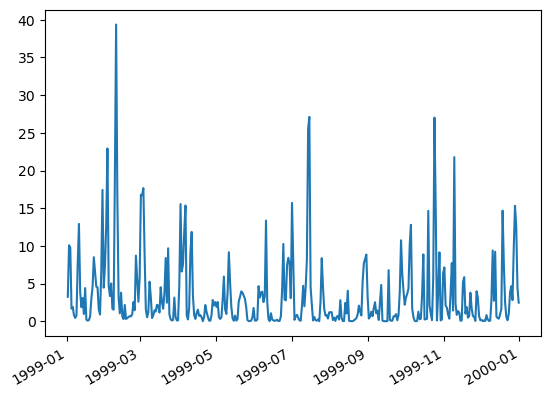

In [7]:
df['mean'].plot()

## Creating a mask with rasterio

An alternative way is to create a mask for the region as a xarray DataArray with the same shape as the data. We can then use to this to select the region.<br>
We start by opening the shapefile with GeoPandas. GeoPandas combines the capabilities of pandas and shapely, providing geospatial operations in pandas.

In [8]:
gdf = gpd.read_file(shapefile)
gdf.geometry

0    MULTIPOLYGON (((149.97620 -37.50516, 149.97620...
Name: geometry, dtype: geometry

There is no `crs` (Coordinate reference System) defined for this shapefile so I'm using the array `crs` which is a standard one. If the `crs` for the shapefile and the data array are different you have to reproject the shapefile.

In [9]:
# define crs, it is not set for this shapefile 
gdf.crs = "EPSG:4326"
# if this is different from the xarray data project then you need to reproject it after defining it
#gdf = gdf.to_crs(epgs='EPGS:...')

WE are using `rasterio` and `odc-geo` to create the mask. `odc-geo` combines geometry features from shapely with CRS from pyproj to provide projection aware Geometry. Here we use `odc.geobox` to provide the mapping between pixels and the geopgraphic projection.  

In [12]:
# use rasterio and odc to create a mask
mask = rasterio.features.geometry_mask(
            gdf.geometry,
            out_shape=precip.odc.geobox.shape,
            transform=precip.odc.geobox.affine,
            all_touched=False,
            invert=False)
mask.shape

(691, 886)

We now have a mask for the selected polygon as a grid with same shape as the precipiation data. However, this is still a numpy array, so we build a xarray DataArray using precip latitude and longitude.

In [13]:
mask = xr.DataArray(mask, dims=('lat', 'lon'),coords=dict(
        lon=precip.lon,
        lat=precip.lat))

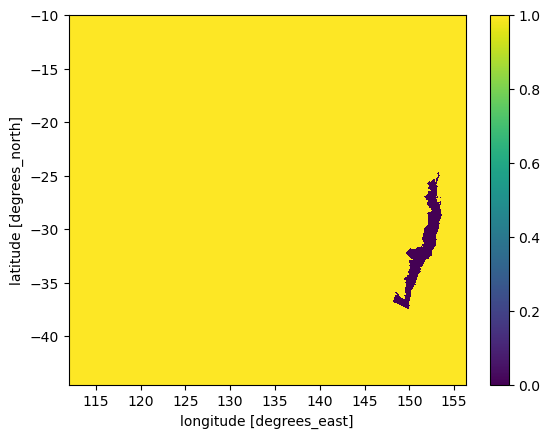

In [14]:
mask.plot()

Finally we use the mask to select the data in the region of interest and calculate the mean.

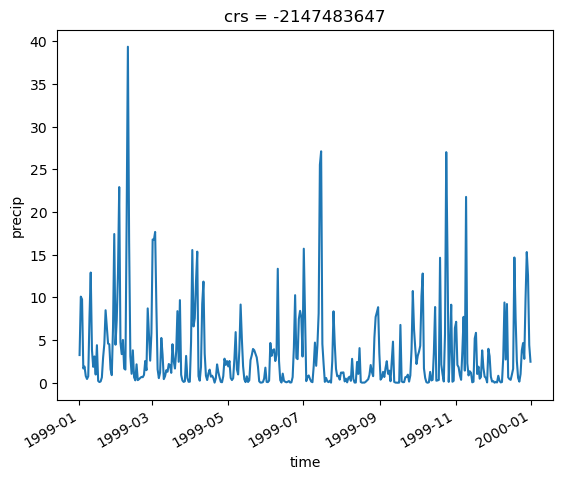

In [15]:
pr_region = precip.where(~mask, drop=True)
meanpr = pr_region.mean(dim=['lat', 'lon'])
meanpr.plot()

This example shows we get the same results with both methods. The first one is quite straightforward, `zonal_stats` does most of the work for us. It is also possible to add your own defined statistic using the `add_stats` argument.
<br>
Here we define a function returning the sum of the min and max.

In [16]:
# first define a new statistic as a function
def new_stat(array):
    """This is meaningless just to prove you can add your own calculation"""
    out = array.min() + array.max()
    return out  

In [17]:
# then we test it on 1 timestep
with rasterio.open(f'netcdf:{ncfile}:precip') as src:
    affine = src.transform
    array = src.read(1)
    newstats = pd.DataFrame(zonal_stats(shapefile, array, 
        affine=affine, stats='mean', add_stats={'mysum': new_stat}))
newstats

,mean,mysum
0,3.245694,57.436523


However, if we want to do a series of calculations on the region, or applying the same process to several variables, or to a multidimensional array, then creating the mask for the region once and then using it to mask the data is easier.<br>
Another case where the mask approach is better is when we want to use the entire timeseries.

## Working with multiple files

So far we only apply this to 365 timesteps and on a relatively small region. If we want to calculate the same on the entire timeseries which consist of 121 files, it is more efficient to parallelise the computation using a dask Client.

In [18]:
from dask.distributed import Client
ncpus = os.environ.get('PBS_NCPUS')
c = Client(n_workers=int(ncpus))
c

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37471 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/37471/status,
Dashboard: /proxy/37471/status,Workers: 2
Total threads: 2,Total memory: 9.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40625,Workers: 2
Dashboard: /proxy/37471/status,Total threads: 2
Started: Just now,Total memory: 9.00 GiB
Comm: tcp://127.0.0.1:44937,Total threads: 1
Dashboard: /proxy/32923/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:44193,


In [19]:
ds = xr.open_mfdataset(ncfiles, parallel=True, chunks={'time': '200MB'})
precip = ds.precip
precip

<xarray.DataArray 'precip' (time: 43981, lat: 691, lon: 886)>
dask.array<concatenate, shape=(43981, 691, 886), dtype=float32, chunksize=(81, 691, 886), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1900-01-01T09:00:00 ... 2020-05-31T09:00:00
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
Attributes:
    cell_methods:                  time: sum
    units:                         mm
    analysis_version_number:       3.01
    long_name:                     Daily precipitation
    number_of_stations_reporting:  2757
    standard_name:                 lwe_thickness_of_precipitation_amount
    frequency:                     daily
    length_scale_for_analysis:     80.0
    grid_mapping:                  crs
    coverage_content_type:         physicalMeasurement
    valid_range:                   [     0. 100000.]

The precipitation data array is ~100GB. We only use a small subset to calculate the mean, however, the data has to be first read and concatenated across the 121 files. Even using the Client, sensible chunks and parallel=True reading the data and calculating the mean took several minutes when I first run this on 2 CPUs.
<br>
As we are effectively using only a small part of the original grid, it helps pre-selecting a smaller area including the region before even concatenating the files.<br>
First we get the region boundaries from the shapefile.

In [20]:
lon_min, lat_min, lon_max, lat_max = gdf.total_bounds
gdf.total_bounds

array([148.20067758, -37.50527776, 153.63833159, -24.69699057])

Then we define a function to select a region based on the boundaries.

In [21]:
def select_region(ds):
    ds = ds.sel(lat=slice(-38, -24), lon=slice(148, 154))
    return ds

We open the files using preprocess argument to select our region of interest from each file before concatenating them. See this [blog](https://climate-cms.org/posts/2023-06-22-mfdataset-preprocess.html) for more information on preprocess.

In [22]:
%%time
ds = xr.open_mfdataset(ncfiles, parallel=True, preprocess=select_region)
precip = ds.precip.chunk({'time': '200MB'})
precip

CPU times: user 1.62 s, sys: 136 ms, total: 1.76 s
Wall time: 4.18 s


<xarray.DataArray 'precip' (time: 43981, lat: 281, lon: 121)>
dask.array<rechunk-merge, shape=(43981, 281, 121), dtype=float32, chunksize=(1460, 281, 121), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1900-01-01T09:00:00 ... 2020-05-31T09:00:00
  * lat      (lat) float32 -38.0 -37.95 -37.9 -37.85 ... -24.1 -24.05 -24.0
  * lon      (lon) float32 148.0 148.1 148.1 148.1 ... 153.9 153.9 153.9 154.0
Attributes:
    cell_methods:                  time: sum
    units:                         mm
    analysis_version_number:       3.01
    long_name:                     Daily precipitation
    number_of_stations_reporting:  2757
    standard_name:                 lwe_thickness_of_precipitation_amount
    frequency:                     daily
    length_scale_for_analysis:     80.0
    grid_mapping:                  crs
    coverage_content_type:         physicalMeasurement
    valid_range:                   [     0. 100000.]

NB this time we are rechunking after we concatenated the files otherwise our chunk size would be limited to the size of the selected array in each file (~10MB).

In [23]:
mask = mask.sel(lat=slice(-38, -24), lon=slice(148, 154))

After applying the same selection to the mask we can calculate the mean as we've done before.

In [24]:
%%time
pr_region = precip.where(~mask)
meanpr = pr_region.mean(dim=['lat', 'lon'])
meanpr = meanpr.compute()

CPU times: user 7.78 s, sys: 1.57 s, total: 9.35 s
Wall time: 4min 26s


We can see now that while it took 4 minutes of walltime, the actual execution was quite fast less than 10 seconds, just by using 2 CPUs.

#### Acknowledgements
Thanks to Kim Reid for providing the use case, shapefile was created by Danielle Udy.